In [52]:
from __future__ import absolute_import, division, print_function, unicode_literals
import IPython.display as display
from PIL import Image
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import pathlib
import datetime
import math
import sys

In [53]:
files = !find ~/bachelor-code/evaluator/*.csv
print(files)

valloss = open(files[2])
loss = open(files[0])

loss =loss.read()
loss = loss.splitlines()
loss = [float(i) for i in loss]

valloss =valloss.read()
valloss = valloss.splitlines()
valloss = [float(i) for i in valloss]

['/home/lasg/bachelor-code/evaluator/lossC.csv', '/home/lasg/bachelor-code/evaluator/loss.csv', '/home/lasg/bachelor-code/evaluator/vallossC.csv', '/home/lasg/bachelor-code/evaluator/valloss.csv']


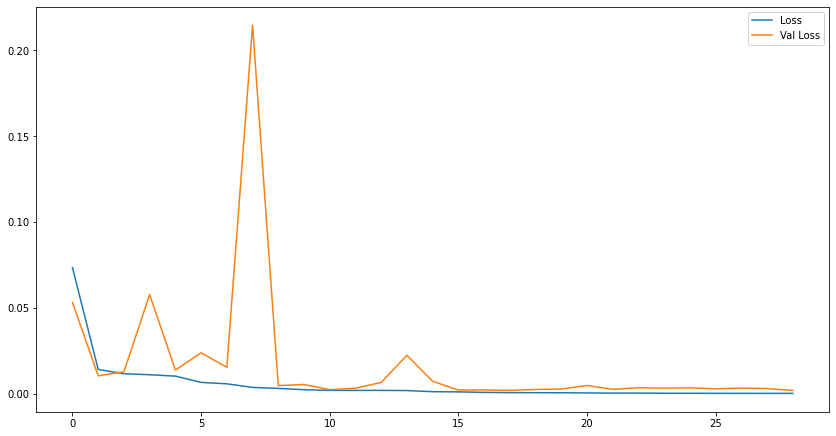

In [51]:
plt.rcParams['figure.figsize'] = [14.2,7.45] 
plt.plot(range(len(loss)),loss)
plt.plot(range(len(loss)),valloss[-29:])
plt.legend(['Loss','Val Loss'])

In [ ]:
list = !cat log.log | cut -d, -f4
list= list[1:]


#Fit kode

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import neptune
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,GlobalAveragePooling2D, Concatenate, Reshape,GlobalMaxPooling2D, Activation, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from classification_models.tfkeras import Classifiers
from PIL import Image
import numpy as np
import pandas
import os
import pathlib
import datetime
import math
import sys

learning_rate = 0.001
image_height =32
image_width = 32
batch_size = 128
numEpochs = 500
num_classes = 10
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# Model
ResNet18, preprocess_input = Classifiers.get('resnet18')
RESNET = ResNet18(include_top=False, weights='imagenet', input_shape=(image_height,image_width,3))
model = tf.keras.Sequential()

model.add(RESNET)
model.add(GlobalAveragePooling2D())
model.add(Dense(512,Activation("sigmoid"),kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(256,Activation("sigmoid"),kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(128,Activation("sigmoid"),kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(10,Activation('softmax')))


optimize = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=optimize,
              metrics=['accuracy'])


RLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2 , verbose=1, mode='min', min_delta=0.0001, cooldown=0)
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience    =10,restore_best_weights=True,verbose=1)



csv = keras.callbacks.CSVLogger('log.log', separator=',', append=False)

model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=numEpochs,
              validation_data=(x_test, y_test),
              callbacks=[csv,RLR,earlyStop],
              shuffle=True)


